In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(500)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
os.listdir(path)

['features.csv',
 'imputed_train_ffill.parquet',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'team_folder',
 'test.parquet',
 'top_100000_rows_sorted_by_weight_descending.parquet',
 'top_10000_rows_sorted_by_weight_descending.parquet',
 'train.parquet']

In [4]:
train_df = pl.read_parquet(path + 'train.parquet/').select(pl.all().shrink_dtype())
y_sr = train_df['responder_6']
train_df = train_df.drop(['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8', 'partition_id']).select(pl.all().shrink_dtype())
print(train_df.shape)
train_df.head()

(47127338, 83)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,null,0.646086,null,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,null,null,-0.08842,-0.995003,-2.635336,-0.196461,-0.618719,null,null,null,null,null,null,null,null,-2.0146,-2.321076,

In [5]:
train_df.estimated_size() / 1e9

15.09433225

In [6]:
def lgb_train(train_data, y):
    weights = train_data['weight']
    
    unique_date_ids = train_data['date_id'].unique()
    train_date_id_cut = 10

    print('max date:', unique_date_ids.max())
    print('date id cut:', train_date_id_cut)
    
    X_train = train_data.filter(pl.col('date_id') > train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight']).select(pl.all().shrink_dtype()).to_pandas()
    X_val = train_data.filter(pl.col('date_id') <= train_date_id_cut).drop(['date_id', 'time_id', 'symbol_id', 'weight']).select(pl.all().shrink_dtype()).to_pandas()

    print(X_train.shape[0] / train_data.shape[0])
    
    y_train = y[:X_train.shape[0]].to_pandas()
    y_val = y[X_train.shape[0]:].to_pandas()
    
    weights_train = weights[:X_train.shape[0]].to_pandas()
    weights_val = weights[X_train.shape[0]:].to_pandas()

    print(X_train.shape)
    display(X_train.head())

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 30,
        'lambda_l2': 100
    }
    
    model = LGBMRegressor(
        **base_params,
        n_estimators=100000
    )

    model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val], callbacks=[log_evaluation(period=50)])#, categorical_feature=['feature_09', 'feature_10', 'feature_11'])

    val_preds = model.predict(X_val)

    plt.figure()
    lgb.plot_metric(model)
    plt.ylim(0, 1)
    plt.show()

    models_path = path + 'my_folder/models/20241229_06/'

    if not os.path.exists(models_path):
        os.makedirs(models_path)

    with open(models_path + "lgb_model.pkl", 'wb') as file:
        pickle.dump(model, file)

    print('Val R2 score is:', r2_score(y_val, val_preds))
    print('Val Weighted R2 score is:', r2_score(y_val, val_preds, sample_weight=weights_val))

    sample_val = X_val.sample(frac=0.001)
    sample_y = y_val.loc[sample_val.index]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X=sample_val, y=sample_y)
    shap_importance = np.abs(shap_values).mean(axis=0)

    return shap_importance

max date: 1698
date id cut: 10
0.9979823176093672
(47032250, 79)


,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,NaN,NaN,NaN,NaN,NaN,-0.463927,-0.512545,-0.152991,0.482539,11,7,76,-0.434036,1.652126,-0.191535,NaN,-0.008406,NaN,-0.936734,-1.381610,0.545427,NaN,1.070315,0.253093,-0.968976,1.312204,NaN,NaN,0.673413,-0.326720,-0.088733,NaN,NaN,NaN,-1.056584,-1.436342,-3.017601,-0.048597,0.347398,NaN,-1.480943,NaN,NaN,-1.815914,NaN,NaN,NaN,-8.783143,-5.687115,-5.822748,NaN,1.041373,NaN,NaN,-0.227077,NaN,-1.237251,1.943876,NaN,-0.442093,-0.108176,0.432111,NaN,NaN,NaN,NaN,NaN,-0.682409,1.636060,-0.244809,-0.958849,1.883245,-0.155963,NaN,NaN,-0.268112,-0.266140,-0.236545,-0.303073
1,NaN,NaN,NaN,NaN,NaN,-0.840003,-1.173913,-0.236570,0.716720,11,7,76,-0.743927,0.076761,-0.471405,NaN,0.474578,NaN,-1.067748,-1.410247,0.671452,NaN,3.128957,1.837293,-0.859743,0.210384,NaN,NaN,2.301881,-0.260708,-0.011012,NaN,NaN,NaN,-0.071690,0.145400,2.150743,0.099982,0.263611,NaN,-1.250795,NaN,NaN,-2.076691,NaN,NaN,NaN,19.357113,4.302351,2.953123,NaN,-0.606083,NaN,NaN,-0.873060,NaN,-1.606691,1.268772,NaN,-1.524955,-0.883235,0.432111,-0.367729,-0.475376,-0.537840,NaN,NaN,-0.888738,0.276393,-0.469570,-0.904619,-0.180099,-0.628653,NaN,NaN,-0.298992,-0.190245,-0.291757,-0.400735
2,NaN,NaN,NaN,NaN,NaN,-0.879289,-0.716709,-0.143400,0.632155,11,7,76,-0.562157,2.602792,0.625479,NaN,0.827231,NaN,-1.467215,-1.619242,-0.087503,NaN,0.029803,1.079485,-0.781449,0.711830,NaN,NaN,-0.129746,0.522336,1.327949,NaN,NaN,NaN,0.941896,0.305618,-3.446326,0.040426,0.245184,NaN,0.982779,NaN,NaN,-1.961928,NaN,-0.876202,2.413551,-16.129784,6.381597,0.689566,NaN,1.454341,NaN,NaN,-1.663755,NaN,-1.222891,0.732520,NaN,-2.276804,-1.464692,0.432111,NaN,1.319477,NaN,-2.78793,-2.998679,-0.437310,3.500467,0.730623,-0.550153,1.317735,-0.143912,NaN,NaN,-0.216961,-0.328180,-0.306173,-0.267477
3,NaN,NaN,NaN,NaN,NaN,-0.613174,-0.771395,-0.132284,0.367407,11,7,76,-0.890800,-0.410585,-0.890166,NaN,-0.827988,NaN,-1.064964,-1.825492,1.114042,NaN,1.049390,0.144263,-0.034898,1.197502,NaN,NaN,-0.358655,-0.533584,-0.535615,NaN,NaN,NaN,-1.885029,-2.222776,-3.241666,-0.022009,0.136357,NaN,0.682396,NaN,NaN,1.409507,NaN,NaN,NaN,-1.173680,-11.293935,-6.600499,NaN,0.255380,NaN,NaN,0.350705,NaN,-2.085006,2.460491,NaN,-0.071393,-0.045488,0.432111,NaN,NaN,NaN,NaN,NaN,-0.840307,-0.283119,-0.613111,-1.058832,-0.385686,-0.950698,NaN,NaN,-0.195895,-0.152973,-0.371045,-0.457318
4,NaN,NaN,NaN,NaN,NaN,-0.722827,-0.961012,-0.165737,0.620468,11,7,76,-1.056144,0.259836,-0.617343,NaN,-0.170700,NaN,-1.364697,-1.705414,0.135380,NaN,0.699537,0.504897,-0.908900,-0.232067,NaN,NaN,0.565601,0.035183,0.547064,NaN,NaN,NaN,-0.119250,-1.294526,-2.305835,0.252497,0.702947,NaN,-2.416272,NaN,NaN,-2.513140,NaN,NaN,NaN,-11.580611,-5.400995,-4.559734,NaN,-1.458585,NaN,NaN,-2.646649,NaN,-2.917889,-0.056680,NaN,-3.884218,-1.762366,0.432111,-0.351236,-0.444281,-0.354554,NaN,NaN,-0.846412,0.354062,-0.383599,-1.279671,0.231471,-0.505367,NaN,NaN,-0.276465,-0.375125,-0.276272,-0.296775


[50]	training's l2: 0.721415	valid_1's l2: 0.50673


<Figure size 640x480 with 0 Axes>

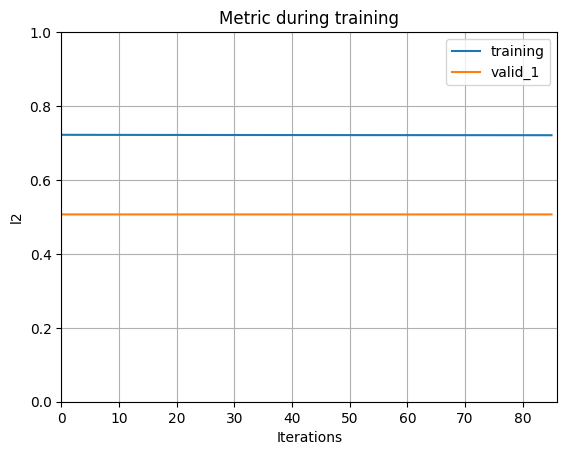

Val R2 score is: -0.00011599592770084044
Val Weighted R2 score is: 5.725523432409396e-05


In [7]:
first_shap_importance = lgb_train(train_df, y_sr)

In [ ]:
cols = train_df.drop(['date_id', 'time_id', 'symbol_id']).columns
imp_df = pd.DataFrame(sorted(zip(cols, first_shap_importance)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [ ]:
print(imp_df.shape)

In [ ]:
imp_df

In [ ]:
plt.figure(figsize=(10, 40))
plt.title("Feature importances")
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.3)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df = train_df.drop(unimportant_cols)
print(train_selected_df.shape)
train_selected_df.head()

In [ ]:
second_shap_importance = lgb_train(train_selected_df, y_sr)